# MLP: Activations and Gradients

After contructing a basic neural network in the previous folder, we now want to progress toward more complex models such as RNNs, GRU, LSTM etc. Before that we want to develop an intuition on role of activations in a NN during training and esp the gradients during backptop. This is essential to understand the historical context in developing advanced architectures. 

While RNNs are 'universally expressive', we will see that they cannot be optimized using the first order gradient based techniques we apply all the time. Why? $\rightarrow$ We need to understand activations, gradients anminituae. 

The intial part of the code remains same with minor readability changes, which I will copy from Karpahty's notebook directly. 

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# character mapping 
stoi = {}
allletters = sorted(set("".join(words)))

stoi = {s:i+1 for i,s in enumerate(allletters)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n_embed = 5
n_hidden = 200

g = torch.Generator().manual_seed(214748367)
# lookup matrix
C = torch.randn((vocab_size,n_embed), generator=g)
# hidden layer - 100 neurons
W1 = torch.randn((block_size*n_embed,n_hidden), generator=g) * 0.2 # use kaiming factor -- see below.
b1 = torch.randn((n_hidden,), generator=g) * 0.01
# Output layer
W2 = torch.randn((n_hidden,vocab_size), generator=g ) * 0.1
b2 = torch.randn((vocab_size,), generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(sum(pm.nelement() for pm in parameters))

8762


In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # construct minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(input = logits, target=Yb)

    #backpass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data -= lr*p.grad
    
    # track loss
    if i % 10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: loss = {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: loss = 3.3746
  10000/ 200000: loss = 2.5185
  20000/ 200000: loss = 2.3660
  30000/ 200000: loss = 2.3382
  40000/ 200000: loss = 2.3650
  50000/ 200000: loss = 2.3431
  60000/ 200000: loss = 2.2183
  70000/ 200000: loss = 2.1210
  80000/ 200000: loss = 1.9901
  90000/ 200000: loss = 1.9770
 100000/ 200000: loss = 2.4881
 110000/ 200000: loss = 2.2999
 120000/ 200000: loss = 2.1279
 130000/ 200000: loss = 1.8696
 140000/ 200000: loss = 2.6417
 150000/ 200000: loss = 1.8930
 160000/ 200000: loss = 2.0928
 170000/ 200000: loss = 2.3200
 180000/ 200000: loss = 1.9419
 190000/ 200000: loss = 2.5217


In [19]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2+ b2
  loss = F.cross_entropy(logits, y)
  # print(split, loss.item())
  return loss

print(f"{split_loss('train'):.4f}")
print(f"{split_loss('val'):.4f}")

2.0903
2.1343


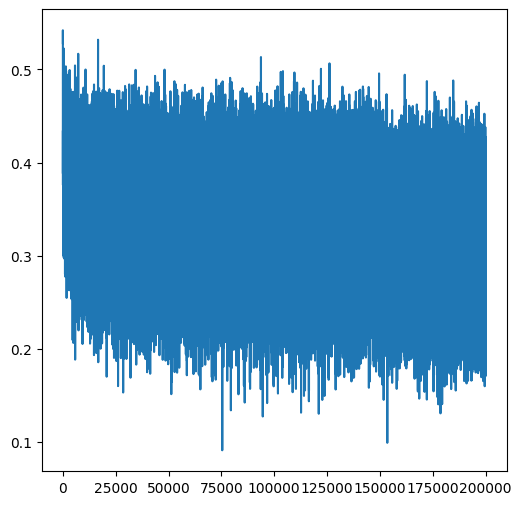

In [20]:
# log loss - J stick appearance no more after good initial guess for W2, b 
plt.figure(figsize=(6,6))
plt.plot(lossi)
plt.show()

In [31]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mria.
kayah.
seel.
nihahaley.
thrstendramer.
zeredielin.
shy.
jen.
edelieananarahayzioh.
karin.
shobergahimiel.
kin.
renelina.
terofius.
kacder.
yarleyeh.
yuma.
mustonde.
hilian.
yansun.


## Randomly initialized loss

We see in randomly initialized W1, b1 etc our initial `NLL loss is ~ 23`. This is too high. Why?

Assume equal probabilities for char output. $\implies P(c) = \frac{1}{27} \implies NLL = -\log(\frac{1}{27}) = 3.295$

In [100]:
# toy example 

logits2 = torch.randn(4)*10
probs2 = torch.softmax(logits2, dim = 0)
loss2 = -probs2.log().mean()
loss2

tensor(14.5898)

Simply multiplying by 10 can throw off the loss by a lot. So clearly random initialization is unstable. In higher dimension tensors with chain of operations, random init, the exponent can blow up very quickly. 

__Rather initialize logits equally can smoothen any edge cases!__

How to do that? <br>
`logits = h @ W2 + b2` $\implies$ if we initialize b2 = 0, W2 as small values close to zero (by multiplying uniformly with 0.1 or so) logits will become stable and initial loss will drop sharply!

In [12]:
b2 = torch.zeros((vocab_size,))
# W2 = torch.randn((n_hidden, vocab_size), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.1

for i in range(max_steps):

    # construct minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(input = logits, target=Yb)
    
    print(loss.item())

    break

3.6537060737609863


In [13]:
logits[0] #nicely spread around 1

tensor([ 0.2761,  0.4772,  0.8766, -2.6415, -0.0283, -0.4598, -0.8176,  0.8232,
        -1.0516, -0.8477,  1.0320, -0.1278,  0.1186, -0.8206,  1.3094,  2.8377,
         0.3267,  0.1396,  1.2354, -0.2298,  0.6311,  1.5496, -0.8442,  0.8164,
        -0.0154, -0.5553,  0.7382], grad_fn=<SelectBackward0>)

The above code outputs initial loss, since we break at `i = 0` itself. By simply multiplying with 0.1, loss _starts_ at 3.6 instead of 20 or 23 earlier!

Also the hockey stick appearance of `lossi` will not happen anymore. Rather it will just be a lot of movement due to batch stochasticity in gradient. 

## Saturation of tanh 

Lets view `h`, the output of the hidden layer. 

In [14]:
h

tensor([[-0.7330, -0.9756,  0.9723,  ...,  0.7706, -0.8647,  0.9699],
        [ 0.9911, -0.2009,  0.9903,  ..., -0.9648, -0.9999,  0.9999],
        [-0.7330, -0.9756,  0.9723,  ...,  0.7706, -0.8647,  0.9699],
        ...,
        [-0.7330, -0.9756,  0.9723,  ...,  0.7706, -0.8647,  0.9699],
        [-0.9301, -0.9829,  0.9913,  ...,  0.9441, -1.0000,  0.9993],
        [ 0.1548, -0.9697,  0.9960,  ..., -0.1318, -0.9975,  0.9251]],
       grad_fn=<TanhBackward0>)

Many values are very close to 1 or -1 (recall graph of `tanh`) since `tanh` is less sensative to very high and very low values and squashes them to 1 and -1 respectively. 

__Lets visualize this better, using a histogram which shows frequency of extreme values (-1 to 1 divided into 50 buckets)__:

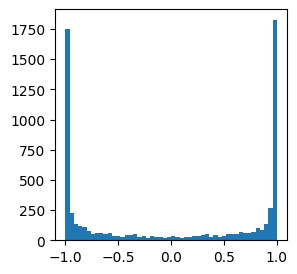

In [15]:
h_list = h.view(-1).tolist()
plt.figure(figsize=(3,3))
plt.hist(h_list, bins=50);

`hpreact` is the variable going into `tanh`! We can visualize that in a histogram similar as above. 

Now, lets check _how many_ entries in `h` lie on the flat tail: i.e. $|h|>0.99$

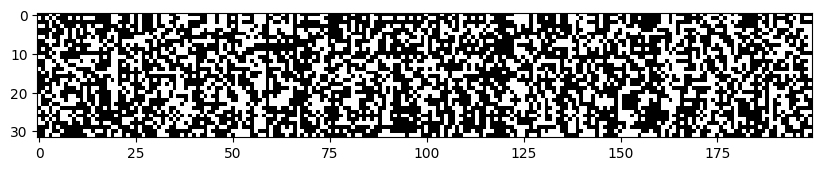

In [16]:
plt.figure(figsize=(10,20))
plt.imshow(h.abs()>0.99, cmap = 'gray', interpolation='nearest')

White -> $|h| > 0.99$ = True <br>
Black -> $|h| > 0.99$ = False

__Situation would be worrisome if an entire column was > 0.99 $\implies$ 'dead neuron'(gradient flow will stop effectively)__

Why is this push of `tanh` to extremes bad? 

Because $\frac{d}{dx}tanh(x) = 1 - x^{2}$ and if x ~ 1, due to which: (intuitively)
- gradient update will be very slow!
- more importantly, that logit will cease to have an effect on the loss, since it lies in the 'flat region' of the `tanh` where changing input barely affects the output

This phenomenon of a _dead neuron_ can also happen with other non linearities (Sigmois, ReLU). <br>
- Ex. For ReLU: if gradient assigned is too high, n.data << 0 $\implies$ ReLU(n.data) = 0 and stays that way for a long time $\implies$ dead 

### To fix this
We must stabilize W1, b1 since `hpreact` depends on them. We can do this my multiplying `b1` by 0.01 and `W1` by 0.2 etc and then check the histogram. (__at initialization__)

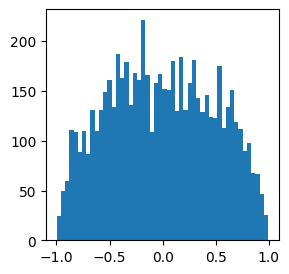

In [149]:
h_list = h.view(-1).tolist()
plt.figure(figsize=(3,3))
plt.hist(h_list, bins=50);

The above __initialization__ avoids extremes (at initialization) and hence, squashing by tanh is not to the extremes.Very few are even above `0.95`, as is evident from the below colormap. 

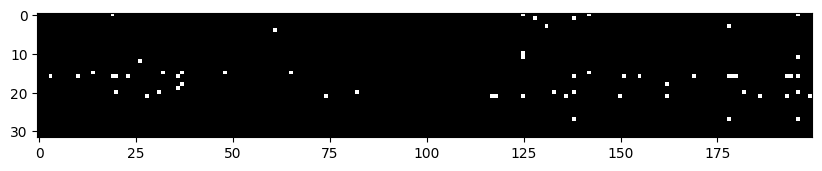

In [150]:
plt.figure(figsize=(10,20))
plt.imshow(h.abs()>0.95, cmap = 'gray', interpolation='nearest')

<span style="color:#FF0000; font-family: 'Bebas Neue'; font-size: 01em;">REMARKS:</span>

Though these initialization issues may seem to have a relatively small impact in our present case, in deep NNs with hundreds of layers, these losses can snowball quickly while becoming difficult to decouple. 


## How to choose a scaling factor during initialization? 

0.1, 0.02 etc being multiplied are just 'magic numbers' which we want to avoid hardcoding. Lets delve deeper into standardizing them. 
Consider the following simple operations: 

In [45]:
x = torch.randn(1000,10)
w = torch.randn(10,200)
y = x @ w

print(x.mean(), y.mean()) # mean of ALL entries
print(x.std(), y.std())

tensor(-0.0088) tensor(0.0191)
tensor(1.0035) tensor(3.2645)


When we set `x = torch.randn(1000,10)` and `w = torch.randn(10,200)`, 10 is the dimension that matters called: _fan-in dimension_. 

When x@w is performed, std become $\sqrt{x_{FanIn}}*\sigma_{og}$

$\implies \sigma' = \sqrt{10}*\sigma_{og}$

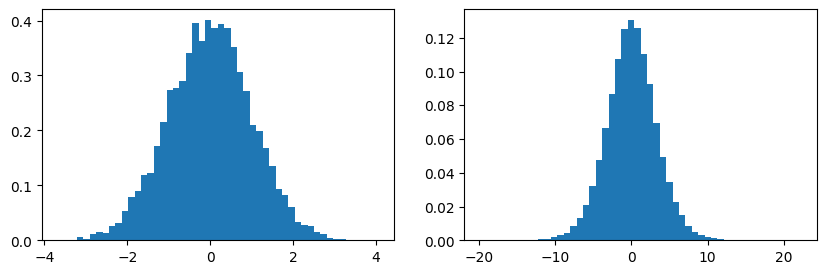

In [49]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.hist(x.view(-1), bins = 50, density=True)

plt.subplot(122)
plt.hist(y.view(-1), bins = 50, density=True)

plt.show()

Similarly, if we see __Kaiming et al.__ , $k = \sqrt{\frac{2}{x_{FanIn}}}$ is chosen as the initializing contant (__i.e. std = k__) for ReLU activation. This is available in pytorch as an inbuilt method to init networks as such: 

[torch.nn.init.kaiming_normal_](https://docs.pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_). On the documentation page:
- [Gain](https://docs.pytorch.org/docs/stable/nn.init.html): To 'counter' the squashing effect (tanh, sigmoid) or nullifying (ReLu for x<0) effect and preserve standard dev = 1

Also note that: we have been checking stability for _forward pass_, however Kaiming shows this init also ensures a smooth backward pass. 

<span style="color:#FF0000; font-family: 'Bebas Neue'; font-size: 01em;">NOTE:</span>
- Due to broad advances in the filed, exact initialization is not _as important_ anymore with introduction of __residual corrections, normalization layers (batch normalization etc), better optimizers (RMSProp, ADAM)__
- Andrej still uses the Kaiming init method, but doesnt bother too much about other aspects of it. 

In [53]:
fan_in = n_embed*block_size #(5*3)
fan_in

15

In [56]:
gain = 5/3 # for tanh activation from torch.nn.init page 
k = gain/(fan_in)**0.5 # kaiming init formula 
k

0.43033148291193524

So ideally, this value $k$ should be multiplied while initializing `W1`:

`W1 = torch.randn(n_hidden, vocab_size) * gain/(fan_in)**0.5`

<hr>